## Question 3

### 1. load files and h2o 

In [2]:
options(warn=-1)
# load library
library(h2o)
library(ggplot2)
library(tidyr)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE) # initialize h2o


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: 'h2o'


The following objects are masked from 'package:stats':

    cor, sd, var


The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc





H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\ALANWA~1\AppData\Local\Temp\RtmpCu4jtS\file1d7c42922838/h2o_Alan_Wang_started_from_r.out
    C:\Users\ALANWA~1\AppData\Local\Temp\RtmpCu4jtS\file1d7c77f64be5/h2o_Alan_Wang_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 581 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.1.3 
    H2O cluster version age:    4 days  
    H2O cluster name:           H2O_started_from_R_Alan_Wang_wkc920 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.33 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       

In [6]:
# load labeled, unlabeled and test data
labeled.frame <- h2o.importFile(path = 'C:/Users/Alan Wang/Desktop/monash/2021 sem1/FIT5201/assignment2/Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'C:/Users/Alan Wang/Desktop/monash/2021 sem1/FIT5201/assignment2/Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'C:/Users/Alan Wang/Desktop/monash/2021 sem1/FIT5201/assignment2/Task2C_test.csv' ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### 2. Train autoencoder and calculate the reconstruction error

In [35]:
reconstruction.train.error <- data.frame(K = seq(20,440,20), reconstruction_error = 0) # dataframe to store errors
i <- 1 # create a count variable

# build a neural network autoencoder based on the training data
for (k in seq(20, 440, 20)){
    NN.model <- h2o.deeplearning(    
        x = 1:ncol(train.frame), # select all pixels
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE, # is it an autoencoder? Yes!
        l2 = 0.1
    )
    # record error
    reconstruction.train.error[i,2] <- sum(h2o.anomaly(NN.model, train.frame))/nrow(train.frame)  # average of Euclidian distances between the input and output of the autoencoder
    # update counter
    i <- i + 1
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [36]:
# check reconstrction error on train data
reconstruction.train.error

K,reconstruction_error
<dbl>,<dbl>
20,0.011894627
40,0.007406801
60,0.004833276
80,0.025909303
100,0.005385183
120,0.114134318
140,0.004723100
160,0.041127239
180,0.005466547


### 3. plot reconstruction error vs k 

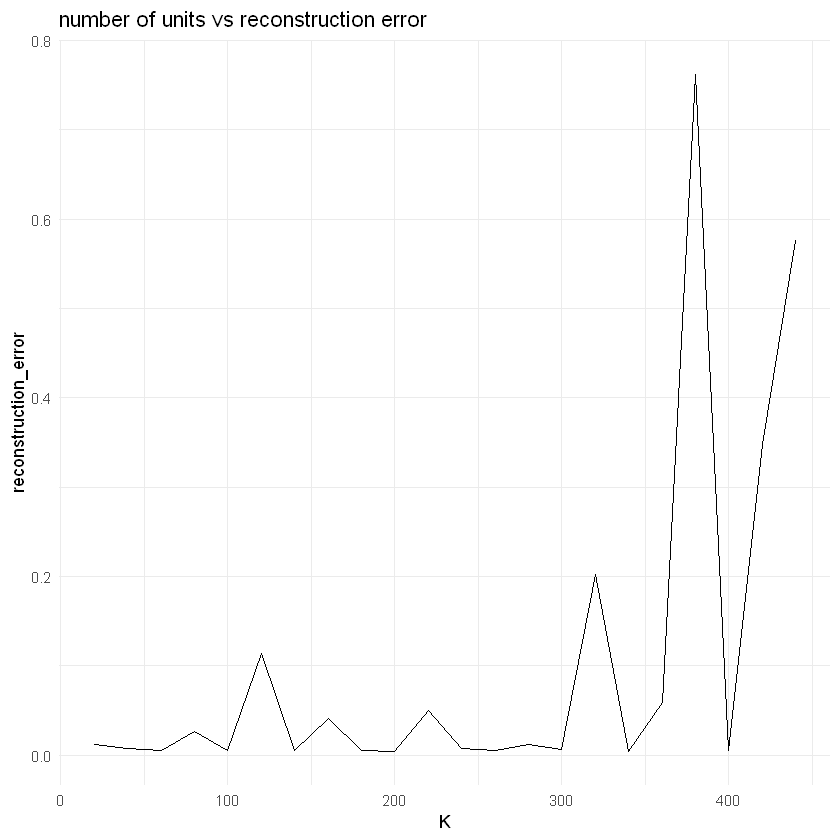

In [39]:
# plot the reconstruction error of model with different units in the hidden layer
ggplot(data = reconstruction.train.error, aes(x = K, y = reconstruction_error)) +
geom_line() +
ggtitle("number of units vs reconstruction error") +
theme_minimal()

### 4. Build a classification model using all the original attributes 

In [40]:
# error rate function
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

In [127]:
classification.test.error <- data.frame(K = seq(20,440,20), nn_error = 0, self_taught_error = 0) # dataframe to store errors
i = 1 # count variable

# build a neural network classifier based on the labeled data
for (k in seq(20, 440, 20)){
    NN.model <- h2o.deeplearning(    
        x = 2:ncol(labeled.frame), # select all pixels 
        y = 1,
        training_frame = labeled.frame, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = FALSE, # is it an autoencoder? NO!
        l2 = 0.1
    )
    
    # predict test labels using the model 
    test.predict <- h2o.predict(NN.model, test.frame)$predict
    # calcualte and record the error
    classification.test.error[i,2] <- error.rate(test.frame$label, test.predict)
    # update counter
    i <- i + 1  
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [64]:
# check test errors
classification.test.error

K,nn_error,self_taught_error
<dbl>,<dbl>,<dbl>
20,0.327,0
40,0.609,0
60,0.581,0
80,0.603,0
100,0.556,0
120,0.509,0
140,0.529,0
160,0.532,0
180,0.489,0


### 5.Build augmented self-taught networks

In [135]:
i = 1 # count variable

# build augmented self-taught networks for different units of hidden layer, k + k 
for (k in seq(20, 440, 20)){
    
    # create an autoencoder with unlabeled data
    NN.extra <- h2o.deeplearning(    
        x = 1:ncol(train.frame), # select all pixels
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE, # is it an autoencoder? Yes!
        l2 = 0.1
    )
     
    # combine original and extra feature
    extra.feature <- h2o.deepfeatures(NN.extra,labeled.frame,layer = 1)   # get extra features
    feature.comb <- h2o.cbind(labeled.frame,extra.feature) # combine together
    
    # create nn model with original + extra feature 
    NN.model <- h2o.deeplearning(    
        x = 2:ncol(feature.comb), # select all pixels + extra features
        y = 1,
        training_frame = feature.comb, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = FALSE, # is it an autoencoder? Yes!
        l2 = 0.1
    )

    # predict test labels using the model 
    test.predict <- h2o.predict(NN.model, test.frame)$predict
    # calcualte and record the error
    classification.test.error[i,3] <- error.rate(test.frame$label, test.predict)
    # update counter
    i <- i + 1 
}
    

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

### 6. plot hidden units vs classification error for 3-layer neural networks and self-taught networks

In [132]:
# change from wide to long format, easy to plot
classification.test.error <- gather(classification.test.error, model, classification_error, nn_error:self_taught_error,factor_key = TRUE)

In [133]:
# check the errors again
classification.test.error

K,model,classification_error
<dbl>,<fct>,<dbl>
20,nn_error,0.358
40,nn_error,0.612
60,nn_error,0.549
80,nn_error,0.567
100,nn_error,0.587
120,nn_error,0.527
140,nn_error,0.561
160,nn_error,0.498
180,nn_error,0.518


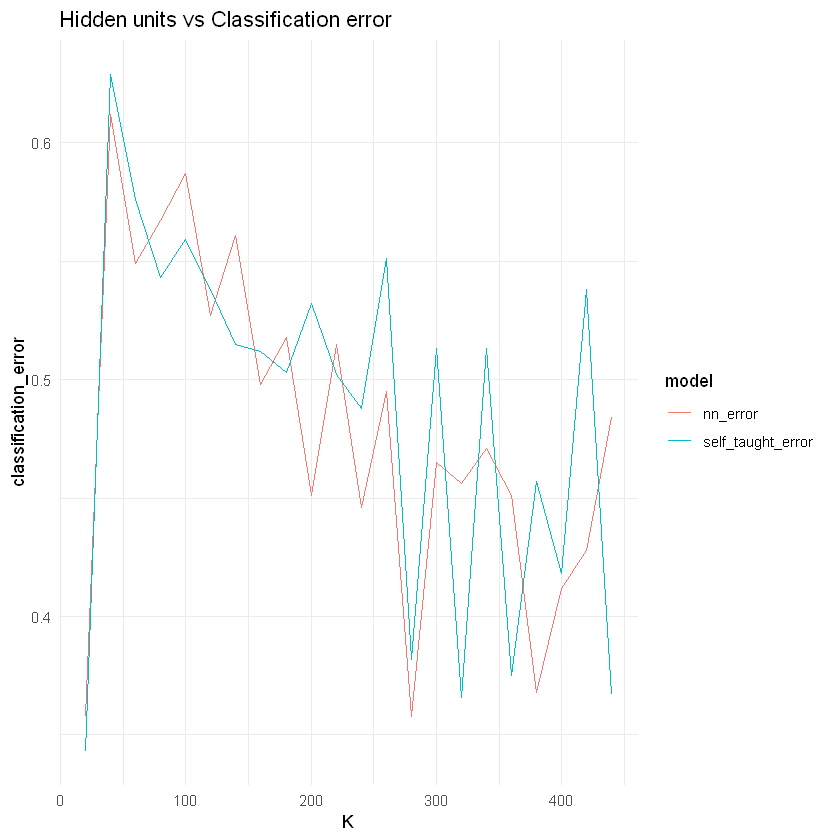

In [134]:
# plot the results
ggplot(data = classification.test.error, aes(x = K, y = classification_error, color = model)) +
geom_line() +
ggtitle("Hidden units vs Classification error") +
theme_minimal()